## NINH GIANG NGUYEN

Fall semester 2024

Data-based project: Company Bankruptcy Prediction

Purpose: Create a dashboard to insert financial metrics so that it can predict if the company faces the likelyhood of bankruptcy. It also implies some important financial indicators so that company can modify their plan and business strategy to avoid being bankrupted

Techniques: Machine learning, Linear regression, Neural network, XGboost, Random Forest, LightGBM, SVM,...

Tools: numpy, panda, matplotlib.pyplot, seaborn, scikit, sklearn, shap,joblib, streamlit,...

Scripts: analysis.py, categorize.py, em.py, application.py

In [1]:
# Import general tools directly
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## PHASE 1: DATA INTERPRETATION AND PREPARATION

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.


## 1. Data exploration

In [2]:
data = pd.read_csv('data.csv')
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [4]:
# Count the number of bankrupt companies (Bankrupt? = 1) and non-bankrupt ones (Bankrupt? = 0)
bankrupt_count = data["Bankrupt?"].value_counts()
print(bankrupt_count)

Bankrupt?
0    6599
1     220
Name: count, dtype: int64


In [5]:
# Check the missing values 
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0]) 

# Check the duplicates
duplicates = data.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

Series([], dtype: int64)
Number of duplicate rows: 0


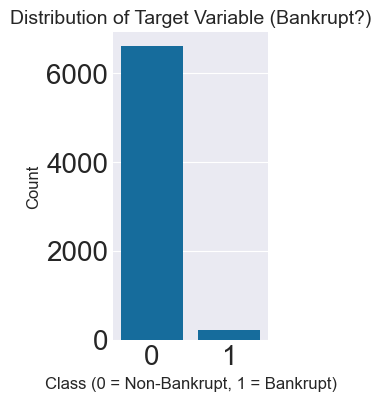

In [6]:
# Visualize the distribution of bankruptcy
plt.figure(figsize=(2, 4))
sns.barplot(x=bankrupt_count.index, y=bankrupt_count.values)
plt.title('Distribution of Target Variable (Bankrupt?)', fontsize=14)
plt.xlabel('Class (0 = Non-Bankrupt, 1 = Bankrupt)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

EXPLORATION: 
* It is recorded that 220 companies were bankrupted from 1999 to 2009, on the other hand, there are 6599 firms still operating
* This dataset doesn't contain any missing values and duplicates because, indeed, all of its variables are known as performance metrics which should be apparently reported on financial documents of each institution.
* The dataset of Company Bankruptcy Prediction is imbalanced because the class of bankrupt companies has significantly 96% fewer examples than non-bankrupt ones, which could affect the model's performance.
* Hence,it is prone to bias, often mistaking minority class for the majority ones, resulting in poor performance on the data of bankrupt companies.
* I solved this by using SMOTE (Synthetic Minority Oversampling Technique) as this dataset is too large

## 2. Data transformation

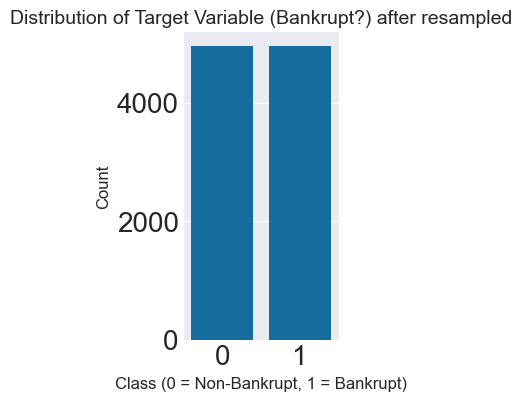

In [7]:
# import tools directly
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features (X) AND target (Y) 
X = data.drop("Bankrupt?", axis =1)  # Financial features of the company
y = data["Bankrupt?"]   # Whether the company was Brankrupted or not

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Resampling data
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize the Resampled Data
plt.figure(figsize=(2, 4))
sns.barplot(x=y_train_resampled.value_counts().index, y=y_train_resampled.value_counts().values)
plt.title('Distribution of Target Variable (Bankrupt?) after resampled', fontsize=14)
plt.xlabel('Class (0 = Non-Bankrupt, 1 = Bankrupt)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

## 3. Data cleaning

- Given that this dataset was a collections of financial reports of many companies; therefore, it includes readable column names, no duplicates or missing values.
- All the feature are in term of rate, ranging between 0 and 1, so no need to do standard scaling
- Furthurmore, this is clean dataset from kaggel, so this step could be temporarily waived, on the way of training data, if there is any underperformance due to data quality issue, I will clean it later

Answer questions
* Does the data make sense?   Yes
* Does the data follow the appropriate rules for its field?    Yes
* Does it prove or disprove your working theory, or bring any insight to light?    Yes
* Can you find trends in the data to help you form your next theory?    Yes

## 4. Feature Engineering

This dataset provides a lot of financial features which can be categorized into some main groups because some of them are calculated by adjusted formula of each other. For examples, there are many ROA variables that are highly correlated, which is known as multicollinearity between independent variables. Although multicollinearity does not affect the regression estimates, it makes them vague, imprecise, and unreliable. Thus, it can be hard to determine how the independent variables influence the Bankrupt? individually.

Therefore, this step aims to consider keeping only one features representing its categorization

In [8]:
# Categorizer class was scripted in categorizer.py file from the same folder
import categorizer
categorizer = categorizer.Categorizer(data=data, thres = 0.9)
selected_data = categorizer.get_selected_data()

In [9]:
print(f'Number of representive features is: {len(selected_data.columns)}')
print(selected_data.columns)

Number of representive features is: 11
Index([' Net Income to Total Assets', ' Borrowing dependency',
       ' Regular Net Profit Growth Rate', ' Net Value Per Share (B)',
       ' Operating Gross Margin', ' Operating profit/Paid-in capital',
       ' Continuous interest rate (after tax)',
       ' Net profit before tax/Paid-in capital',
       ' Working capitcal Turnover Rate', ' Debt ratio %',
       ' Current Liabilities/Liability'],
      dtype='object')


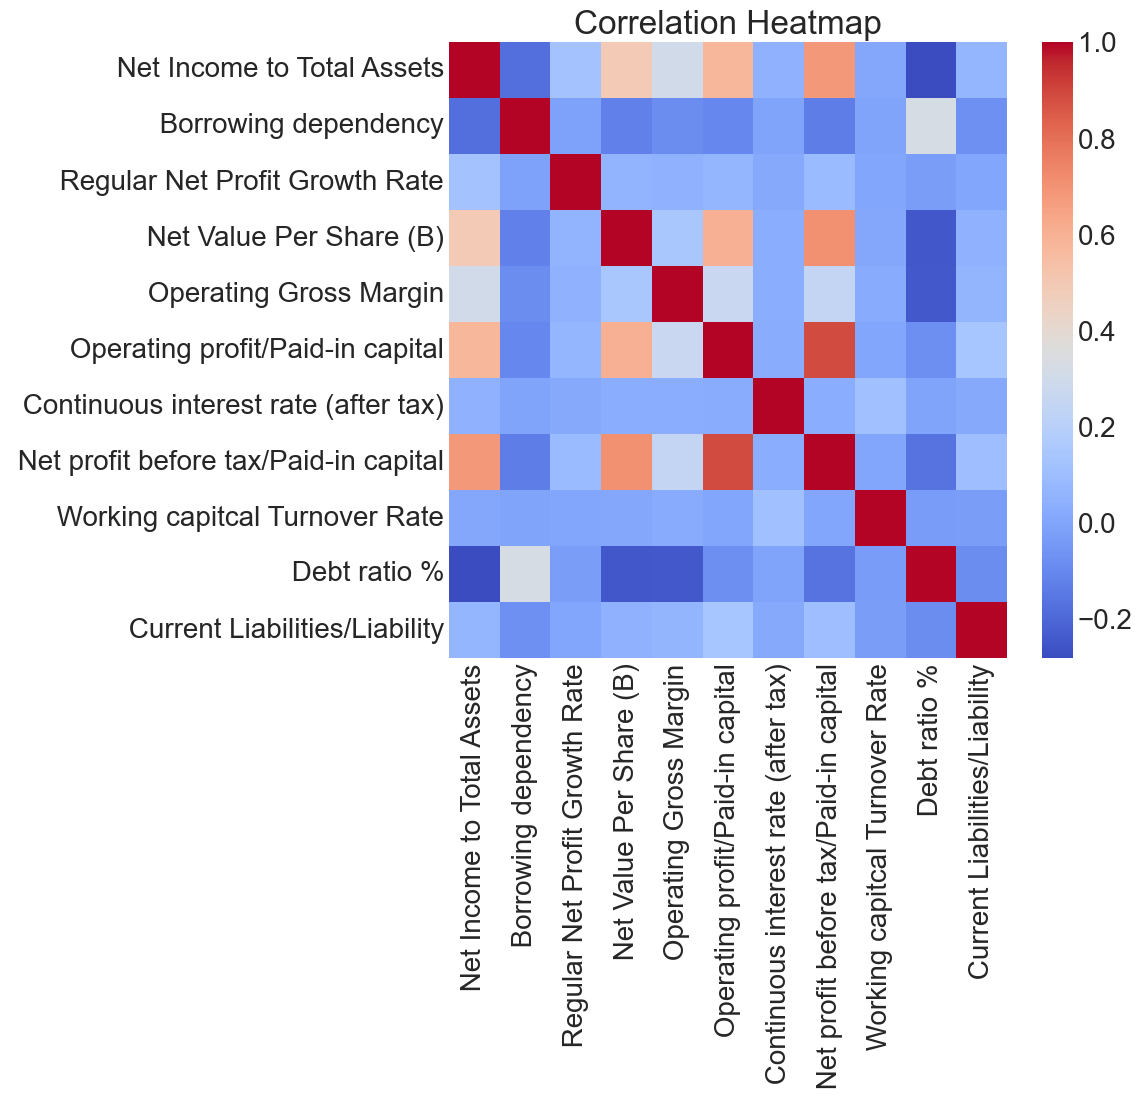

In [10]:
corr_matrix = selected_data.corr()
plt.figure(figsize=(9,8))
sns.heatmap(corr_matrix, annot = False, cmap = "coolwarm")
plt.title('Correlation Heatmap')
plt.show()

EXPLORATION
* After focusing on the representive features, the correlation matrix of selected data has lower entities, shown by lighter color (closer to 0) in heatmap. This indicates that the remaining features have less relevence to each other, claiming fewer multicolllinearity.

## PHASE 2: EXPLORATORY DATA ANALYSIS (EDA)

# 1. Univariate Analysis
This step helps us understand the distribution of individual features and the target variable.

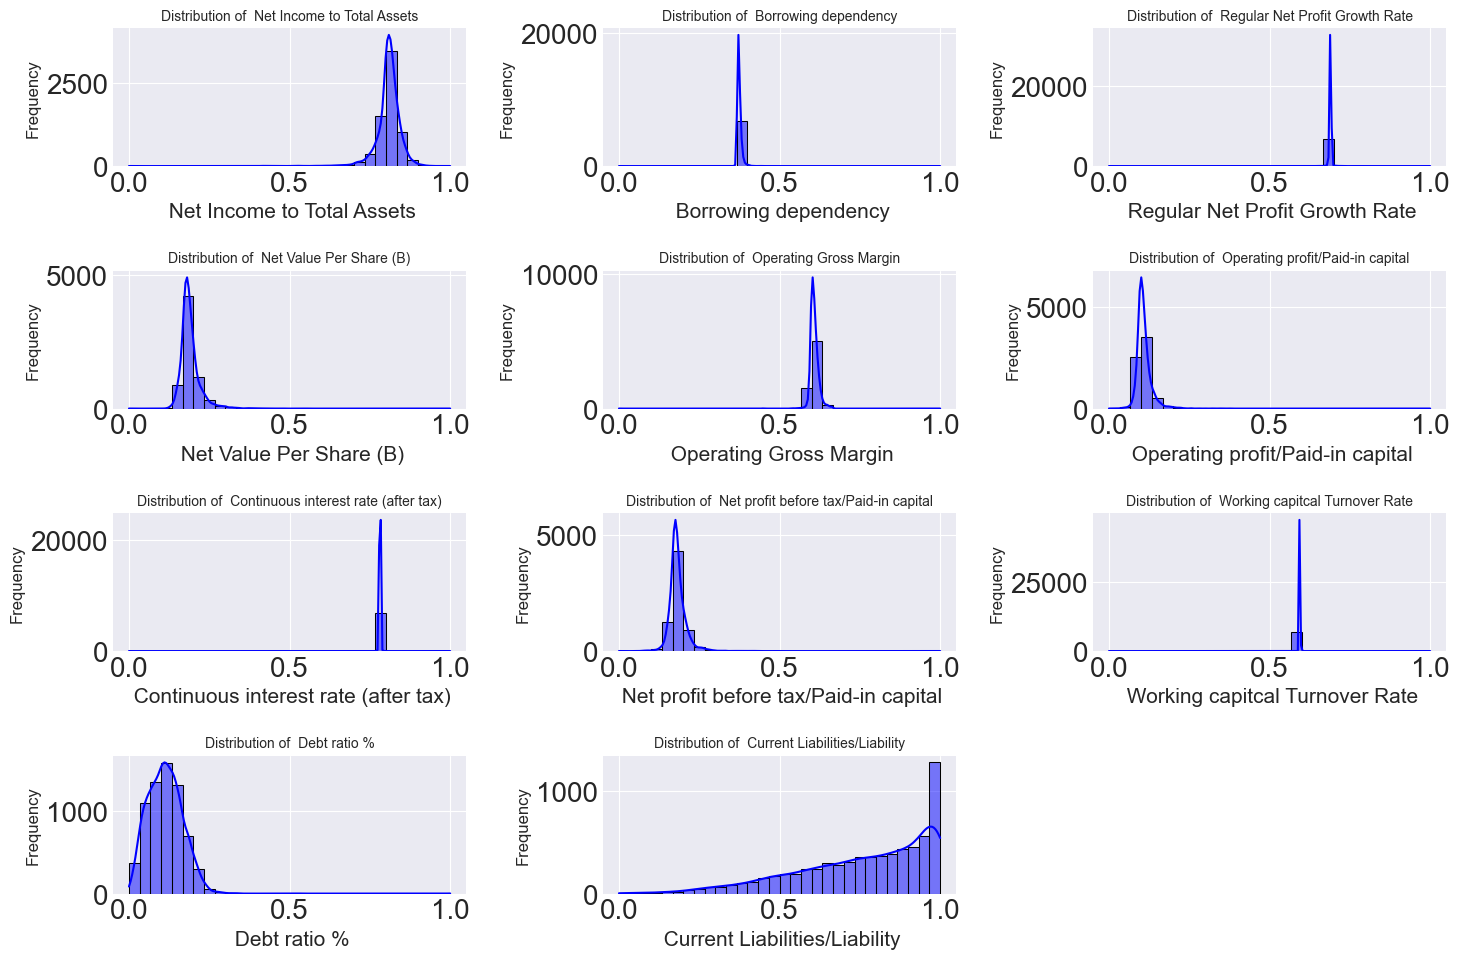

In [11]:
# Plot the distribution of key features
plt.figure(figsize=(15,10))

for i, feature in enumerate(selected_data.columns, 1):
    n = len(selected_data.columns)
    plt.subplot(4, n//4 + 1, i)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}', size=10)
    plt.xlabel(feature, size = 15)
    plt.ylabel('Frequency', size = 12)

plt.tight_layout()
plt.show()

In [12]:
# Analysis class was scripted in analysis.py file from the same folder
import analysis

analysis = analysis.Analysis(selected_data)

group1 = []
group2 = []
group3 = []


for feature in analysis.data.columns:
 
    mean = analysis.data[feature].mean().mean()
    interval, range = analysis.range(analysis.data[feature], sig_level=0.05)
    print(f'Mean of {feature} is {round(mean, 2)} with 95% confident interval {interval}')

    if range <= 0.01: 
        group1.append(feature)
    elif range <= 0.1 and range > 0.01:
        group2.append(feature)
    else: 
        group3.append(feature)

Mean of  Net Income to Total Assets is 0.81 with 95% confident interval (0.748, 0.859)
Mean of  Borrowing dependency is 0.37 with 95% confident interval (0.37, 0.385)
Mean of  Regular Net Profit Growth Rate is 0.69 with 95% confident interval (0.688, 0.691)
Mean of  Net Value Per Share (B) is 0.19 with 95% confident interval (0.154, 0.245)
Mean of  Operating Gross Margin is 0.61 with 95% confident interval (0.594, 0.63)
Mean of  Operating profit/Paid-in capital is 0.11 with 95% confident interval (0.083, 0.149)
Mean of  Continuous interest rate (after tax) is 0.78 with 95% confident interval (0.781, 0.782)
Mean of  Net profit before tax/Paid-in capital is 0.18 with 95% confident interval (0.15, 0.226)
Mean of  Working capitcal Turnover Rate is 0.59 with 95% confident interval (0.594, 0.594)
Mean of  Debt ratio % is 0.11 with 95% confident interval (0.032, 0.203)
Mean of  Current Liabilities/Liability is 0.76 with 95% confident interval (0.361, 0.998)


EXPLORATION
* Group 1: Fixed-metric features
  - Continuous interest rate concentrated at 0.78, (maybe because interest rate is set by Federal Reserve in United State)
  - Regular net profit growth rate concentrated at 0.69
  - Working capital turnover rate concentrated at 0.59
    
  => These metrics show little variability across firms, suggesting they may not play a critical role in distinguishing bankruptcy likelihood among companies in this dataset. However, they could hold greater significance in a time-series or panel dataset where trends over time are analyzed.

* Group 2: Features with narrow ditribution
  -  Persistent EPS (earning per share) in Last Four Season centered at 0.23, mostly ranging between 0.192 and 0.277
  -  Net Value per Share centered at 0.19, mostly ranging between 0.154 and 0.245
  -  Current Liability / Equity centered at 0.33, mostly ranging between 0.327 and 0.341
  -  Operating gross margin centered at 0.61, mostly ranging between 0.594 and 0.63
 
  => These features exhibit limited variability, indicating their impact on bankruptcy prediction may be minimal. While they might provide some insights, their influence is likely slight in this cross-sectional analysis.
  
* Group 3: Features with wide ditribution
  - ROA centered at 0.56, mostly ranging between 0.457 and 0.654
  - Current Liability / Liability's distribution  is highly skewed to the left, with most values concentrated near 1.0. A small number of companies have very low values, possibly indicating outliers.
  - Net worth / assets centered at 0.89, mostly ranging between 0.797 and 0.968.

  => These features display significant variability, suggesting they might have a substantial effect on predicting bankruptcy. Their broader range provides more differentiation among firms, making them potentially important indicators in this analysis.


# 2. Bivariate and Multivariate Analysis

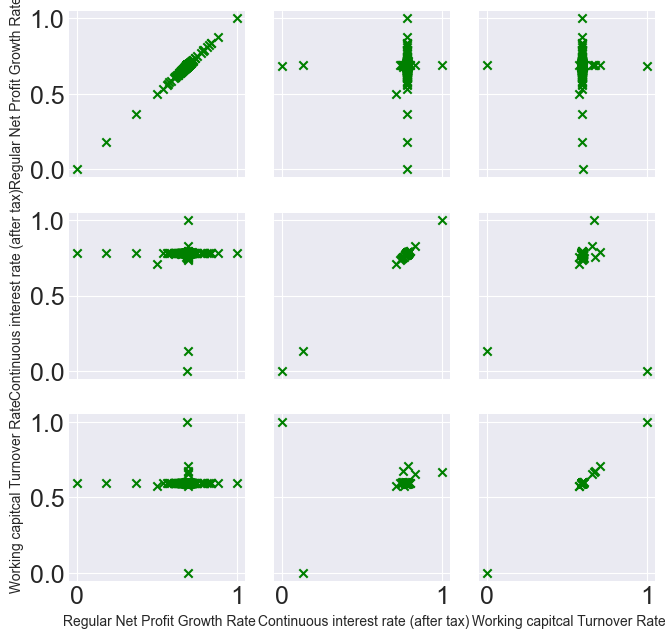

(<Figure size 700x700 with 9 Axes>,
 array([[<Axes: ylabel=' Regular Net Profit Growth Rate'>, <Axes: >,
         <Axes: >],
        [<Axes: ylabel=' Continuous interest rate (after tax)'>, <Axes: >,
         <Axes: >],
        [<Axes: xlabel=' Regular Net Profit Growth Rate', ylabel=' Working capitcal Turnover Rate'>,
         <Axes: xlabel=' Continuous interest rate (after tax)'>,
         <Axes: xlabel=' Working capitcal Turnover Rate'>]], dtype=object))

In [13]:
analysis.pair_plot(data_vars=group1, fig_sz=(7,7))

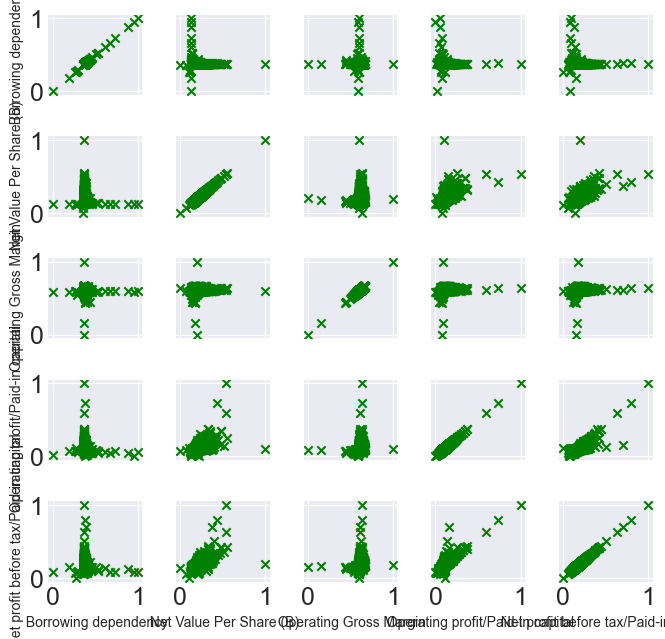

(<Figure size 700x700 with 25 Axes>,
 array([[<Axes: ylabel=' Borrowing dependency'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel=' Net Value Per Share (B)'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel=' Operating Gross Margin'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel=' Operating profit/Paid-in capital'>, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel=' Borrowing dependency', ylabel=' Net profit before tax/Paid-in capital'>,
         <Axes: xlabel=' Net Value Per Share (B)'>,
         <Axes: xlabel=' Operating Gross Margin'>,
         <Axes: xlabel=' Operating profit/Paid-in capital'>,
         <Axes: xlabel=' Net profit before tax/Paid-in capital'>]],
       dtype=object))

In [14]:
analysis.pair_plot(data_vars=group2, fig_sz=(7,7))

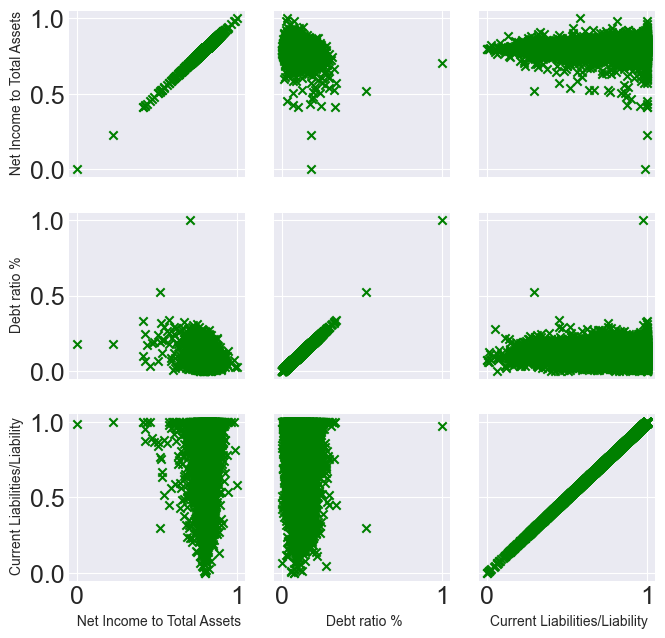

(<Figure size 700x700 with 9 Axes>,
 array([[<Axes: ylabel=' Net Income to Total Assets'>, <Axes: >, <Axes: >],
        [<Axes: ylabel=' Debt ratio %'>, <Axes: >, <Axes: >],
        [<Axes: xlabel=' Net Income to Total Assets', ylabel=' Current Liabilities/Liability'>,
         <Axes: xlabel=' Debt ratio %'>,
         <Axes: xlabel=' Current Liabilities/Liability'>]], dtype=object))

In [15]:
analysis.pair_plot(data_vars=group3, fig_sz=(7,7))

EXPLORATION:
* Group 1: Fixed-Metric Features
    - This group contains features with data values predominantly concentrated in a specific zone. While there are some outliers, these outliers tend to align along nearly horizontal or vertical lines, staying relatively close to the central tendency.
    - Implications: The lack of significant variability within this group suggests these features may have limited influence in distinguishing bankrupt from non-bankrupt companies.


* Group 2: Features with Narrow Distributions
    - This group includes features where data points are tightly clustered in a slightly broader zone compared to the fixed-metric group. While most values remain concentrated, the outliers here show more variety, although they still align along nearly horizontal or vertical axes.
    - Implications: The limited but slightly wider distribution of these features could imply some degree of relevance in predicting bankruptcy. The alignment of outliers within predictable patterns suggests they may represent anomalies but are less likely to indicate entirely distinct behaviors or firm characteristics.


* Group 3: Features with Wide Distributions
    - Features in this group exhibit substantial variability, with data points forming clusters across a significantly larger area. Outliers in this group are more dispersed and appear randomly distributed rather than aligning along specific axes.
    - Implications: The broader variability indicates these features could play a more critical role in distinguishing bankrupt companies, as they capture a wider range of firm characteristics. The random distribution of outliers might suggest the presence of unique cases, potentially reflecting bankrupt companies or other extreme financial scenarios.


* Outlier Prediction 
    - It is hypothesized that these outliers, especially those observed in the wide-distribution group, may represent bankrupt companies or firms exhibiting financial instability.
    - Further exploration during model development will focus on validating this hypothesis and understanding how these features contribute to bankruptcy prediction.



## PHASE 3: MODEL DEVELOPMENT

# 1. Baseline Model
## Logistic Regression: 
provides a benchmark for comparison, predicted to have poor performance


In [16]:
# importing tools directly
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

In [17]:
# Run the model
log_model = LogisticRegression(random_state=42, max_iter=10000)
log_model.fit(X_train_resampled, y_train_resampled)
y_pred = log_model.predict(X_test)
y_pred_prob = log_model.predict_proba(X_test)[:, 1] # return the probability of being bankrupted 

In [18]:
# check accuracy of model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.86      1647
           1       0.07      0.45      0.11        58

    accuracy                           0.76      1705
   macro avg       0.52      0.61      0.49      1705
weighted avg       0.94      0.76      0.84      1705

AUC-ROC: 0.6078240479031887


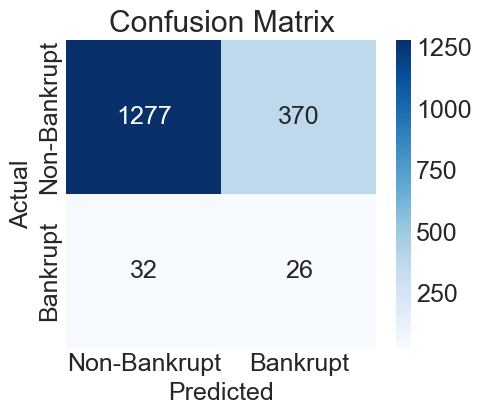

In [19]:
# confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


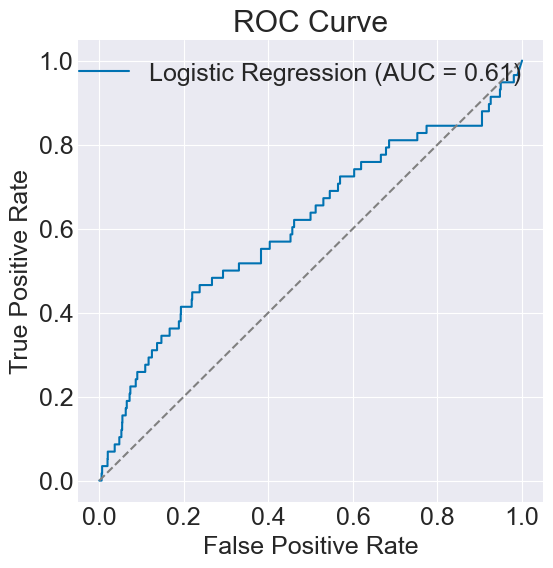

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_prob)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

EXPLORATION
* Classification Report Analysis
reveals significant disparities in the model's ability to handle the two classes (0: Non-Bankrupt, 1: Bankrupt):
    - For class 0 (Non-Bankrupt): precision is 0.98 => the model is highly accurate in predicting non-bankrupt companies as non-bankrupt.
    - For class 1 (Bankrupt): precision is  only 0.07 => when the model predicts a company as bankrupt, it's often incorrect. And, Recall is 0.45, indicating the model catches less than half of the actual bankrupt companies.
    - Accuracy is 76%, but this is misleading given the imbalance in class performance.

* AUC-ROC Analysis
  - The AUC-ROC score of 0.607 indicates that the model has only slightly better discrimination ability than random guessing (0.5) by 10%

* Confusion Matrix Analysis
  - True Negatives (1277): The model correctly identifies a significant portion of non-bankrupt companies.
  - False Positives (370): A large number of non-bankrupt companies are incorrectly predicted as bankrupt, which could lead to unnecessary concerns in practice.
  - False Negatives (32): The model fails to identify 32 bankrupt companies, which is critical in the context of predicting financial distress.
  - True Positives (26): Only 26 bankrupt companies are correctly predicted as bankrupt.
 
* In conclusion: Logistic Regression may be too simple for this problem => need more advanced model


## Expectation-Maximization: 
generate distribution of data in the biggest cluster and find outliers (data point that don't belong to any clusters) and check if they are the case of bankruptcy

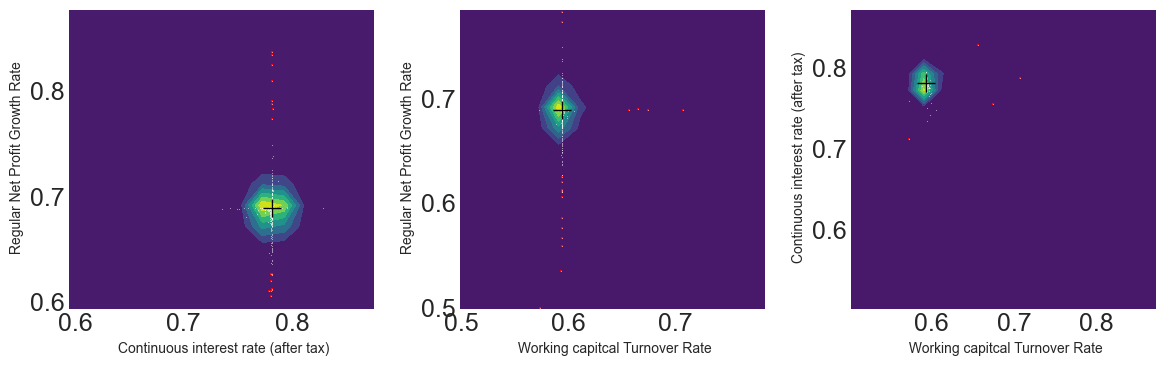

In [21]:
# EM class was scripted in em.py file from the same folder
import em
em1 = em.EM(selected_data)
em1.plot_contour(group1, 0.05, (12,4), title = "The gaussian distribution of fixed-metric features" )

*                                               The Gaussian distributions of fixed-metric features

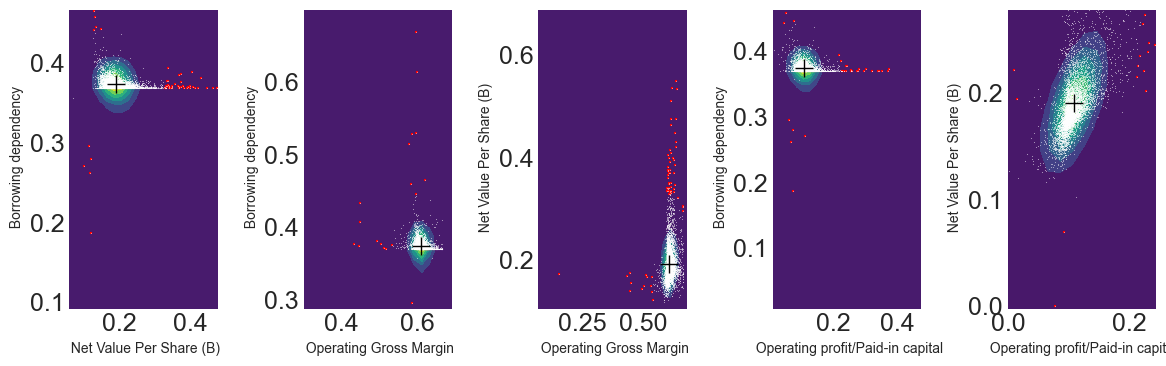

In [22]:
em2 = em.EM(selected_data)
em2.plot_contour(group2, 0.05, (12,4), title = "The gaussian distribution of features with narrow range")

*                                            The gaussian distribution of features with narrow range

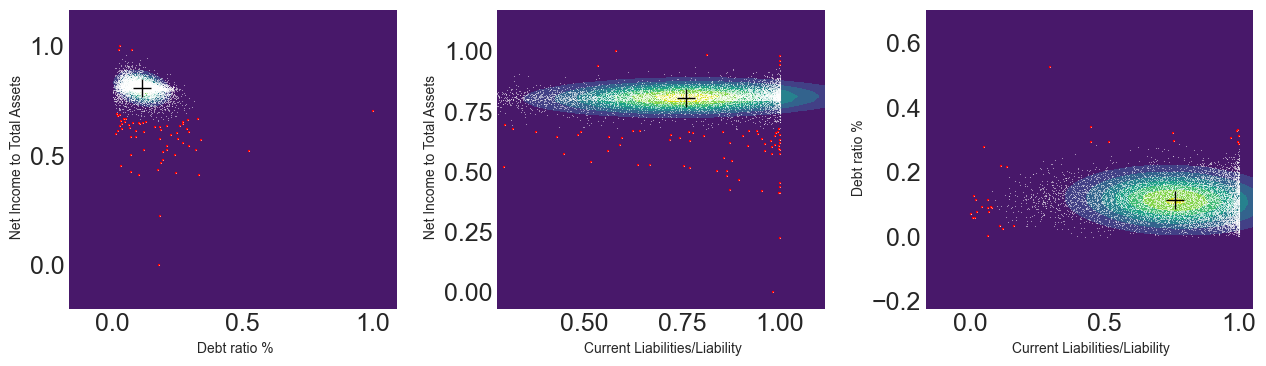

In [23]:
em3 = em.EM(selected_data)
em3.plot_contour(group3, 0.05, (13,4), 0.4 , title = "The gaussian distribution of features with wide range")

*                                               The gaussian distribution of features with narrow range

In [24]:
# set1 = em1.get_outliers_index()
# set2 = em2.get_outliers_index()
set3 = em3.get_outliers_index()
pred_bankrupt = set(set3)
actual_bankrupt = y[y == 1].index.to_list()

k = 0
for i in pred_bankrupt:
    if i in actual_bankrupt:
        k+= 1

print("Accuracy of evaluating bankruptcy based on outliers is ", k / len(pred_bankrupt))

Accuracy of evaluating bankruptcy based on outliers is  0.34615384615384615


EXPLORATION
* Evaluate the bankruptcy based on the outlier status is even worse than logistic regression with the accuracy = 27%
* So we not gonna use outlier analysis to flag as an additional feature in the model to assess its predictive power as we infer in pre

# 2. Advanced model

In [25]:
# import tools directly
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout

## Random Forest:

In [26]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv = 5, scoring='roc_auc', n_jobs = -1, verbose =1)
grid_search_rf.fit(X_train, y_train)
rf_best = grid_search_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))   
print("Random Forest AUC-ROC:", roc_auc_score(y_test, rf_best.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.56      0.34      0.43        58

    accuracy                           0.97      1705
   macro avg       0.77      0.67      0.70      1705
weighted avg       0.96      0.97      0.96      1705

Random Forest AUC-ROC: 0.9368391851433119


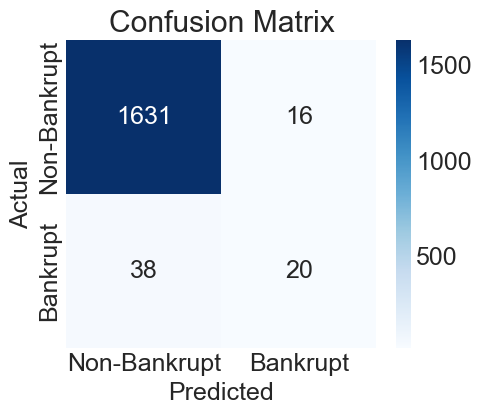

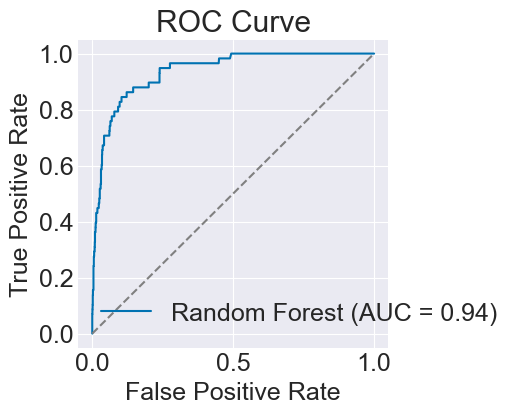

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, rf_best.predict_proba(X_test)[:,1])

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, rf_best.predict_proba(X_test)[:,1])))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## XGBoost

In [28]:
xgb = XGBClassifier(random_state = 42, 
                   scale_pos_weight = (len(y_train) - sum(y_train))/sum(y_train))
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
grid_search_xgb.fit(X_train, y_train)

xgb_best = grid_search_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))   
print("XGBoost AUC-ROC:", roc_auc_score(y_test, xgb_best.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.54      0.38      0.44        58

    accuracy                           0.97      1705
   macro avg       0.76      0.68      0.71      1705
weighted avg       0.96      0.97      0.97      1705

XGBoost AUC-ROC: 0.9376086091744656


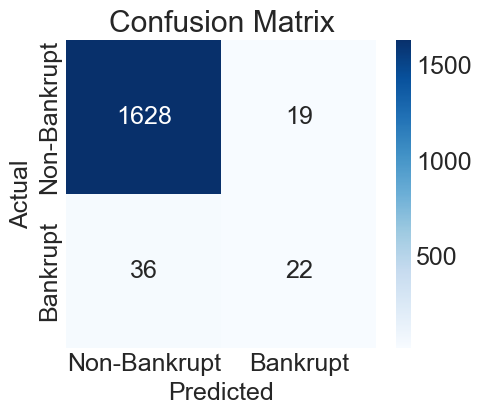

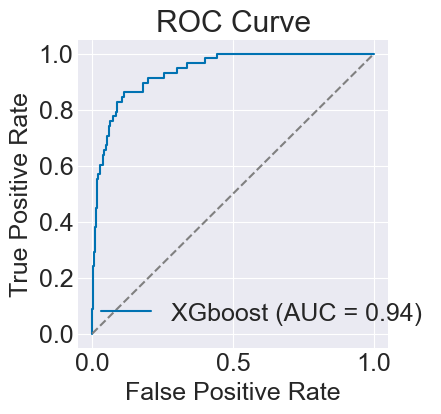

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='XGboost (AUC = {:.2f})'.format(roc_auc_score(y_test, xgb_best.predict_proba(X_test)[:,1])))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## LightGBM

In [30]:
lgbm = LGBMClassifier(random_state=42, class_weight="balanced",  verbose=-1)  # Handle class imbalance

param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 1]
}

grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search_lgbm.fit(X_train, y_train)

lgbm_best = grid_search_lgbm.best_estimator_
y_pred_lgbm = lgbm_best.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("LightGBM AUC-ROC:", roc_auc_score(y_test, lgbm_best.predict_proba(X_test)[:, 1]))

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1647
           1       0.71      0.34      0.47        58

    accuracy                           0.97      1705
   macro avg       0.85      0.67      0.73      1705
weighted avg       0.97      0.97      0.97      1705

LightGBM AUC-ROC: 0.9427276343613257


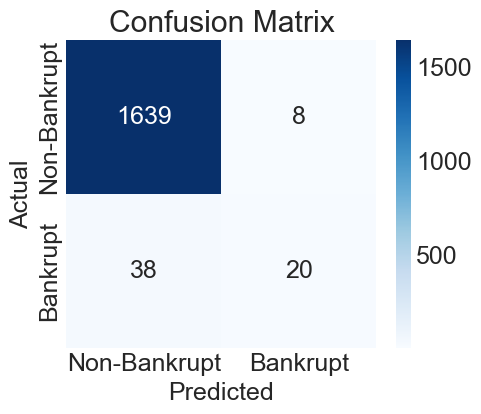

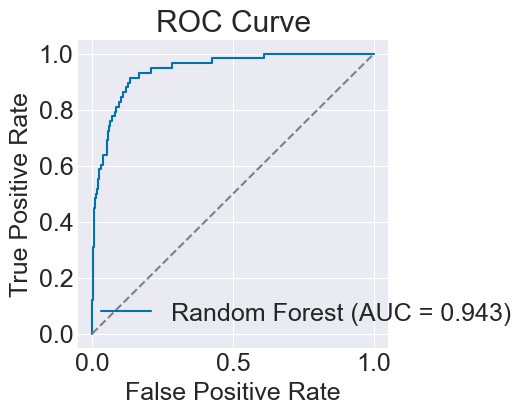

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, lgbm_best.predict_proba(X_test)[:,1])

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, lgbm_best.predict_proba(X_test)[:,1])))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Support Vector Machine (SVM)

In [32]:
# svm = SVC(probability=True, random_state=42, class_weight="balanced")
# param_grid_svm = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
# grid_search_svm = GridSearchCV(svm, param_grid_svm, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
# grid_search_svm.fit(X_train, y_train)

# svm_best = grid_search_svm.best_estimator_
# y_pred_svm = svm_best.predict(X_test)
# print("SVM classification Report:")
# print(classification_report(y_test, y_pred_svm))
# print("SVM AUC-ROC:", roc_auc_score(y_test, svm_best.predict_proba(X_test)[:,1]))

## Neural networks

In [33]:
from keras.utils import to_categorical

y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

nn.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
history = nn.fit(X_train, y_train_nn, validation_data=(X_test, y_test_nn), epochs=20, batch_size=32, verbose=1)

y_pred_nn = nn.predict(X_test)
y_pred_nn_labels = np.argmax(y_pred_nn, axis=1)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_labels))
print("Neural Network AUC-ROC:", roc_auc_score(y_test, y_pred_nn[:, 1]))

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9264 - loss: 60033816.0000 - val_accuracy: 0.9648 - val_loss: 10656324.0000
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9328 - loss: 17330278.0000 - val_accuracy: 0.9660 - val_loss: 2907349.0000
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9454 - loss: 5729852.0000 - val_accuracy: 0.9443 - val_loss: 350465.3438
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9340 - loss: 2014043.2500 - val_accuracy: 0.9660 - val_loss: 247678.0156
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9346 - loss: 1929701.7500 - val_accuracy: 0.9660 - val_loss: 148180.5000
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9351 - loss: 1240745.5000 - val_accuracy: 0.5120 - val_loss: 150818.1562
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9257 - loss: 383573.2500 - val_accuracy: 0.9660 - val_loss: 34114.7109
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━

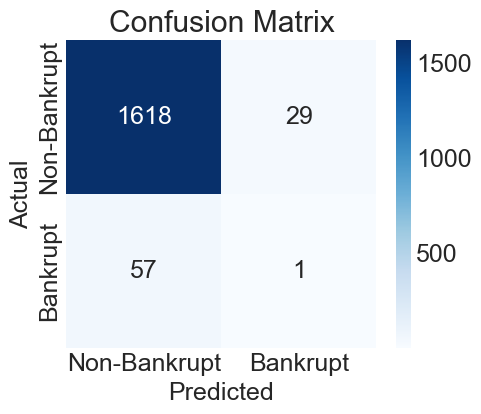

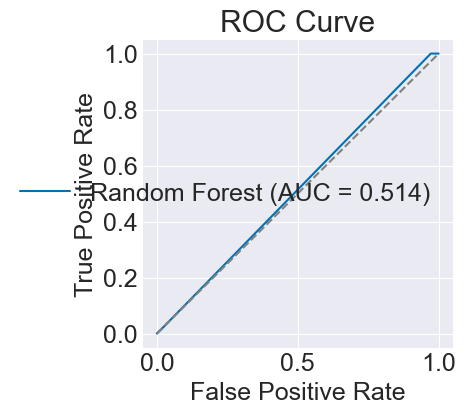

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred_nn_labels)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn[:, 1])

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred_nn[:, 1])))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Evaluate Model


- Random Forest, XGBoost, and LightGBM achieve excellent accuracy (~94%), with LightGBM showing the highest accuracy of 94.3%.
- Neural Network performs poorly with just 56.6% accuracy, indicating no significant improvement over random guessing.
- SVM was skipped due to excessive runtime.
- LightGBM is the most resource-efficient model, with lower runtime and memory consumption compared to XGBoost.

In [35]:
# Helper function to print performance metrics
def print_metrics(model_name, y_true, y_pred, y_proba=None):
    print(f"Performance for {model_name}:")
    print(classification_report(y_true, y_pred))
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        print(f"AUC-ROC: {auc:.4f}")
    print("-" * 50)

# Random Forest
print_metrics("Random Forest", y_test, y_pred_rf, rf_best.predict_proba(X_test)[:, 1])

# XGBoost
print_metrics("XGBoost", y_test, y_pred_xgb, xgb_best.predict_proba(X_test)[:, 1])

# LightGBM
print_metrics("LightGBM", y_test, y_pred_lgbm, lgbm_best.predict_proba(X_test)[:, 1])

# Neural Network
# print_metrics("Neural Network", y_test, y_pred_nn_labels, y_pred_nn[:, 1])

Performance for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.56      0.34      0.43        58

    accuracy                           0.97      1705
   macro avg       0.77      0.67      0.70      1705
weighted avg       0.96      0.97      0.96      1705

AUC-ROC: 0.9368
--------------------------------------------------
Performance for XGBoost:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.54      0.38      0.44        58

    accuracy                           0.97      1705
   macro avg       0.76      0.68      0.71      1705
weighted avg       0.96      0.97      0.97      1705

AUC-ROC: 0.9376
--------------------------------------------------
Performance for LightGBM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1647
           1       0.

Based on the performance metrics provided, the LightGBM model should be selected as the best model. Here's the reasoning:

1. Evaluation of Performance Metrics
* Accuracy
    - All three models (Random Forest, XGBoost, and LightGBM) achieve a high accuracy of 97%, indicating strong overall performance in predicting both classes.
* Precision, Recall, and F1-Score
    - Class 1 (Bankrupt Companies): LightGBM shows a slight improvement in metrics compared to Random Forest and XGBoost for the minority class (1), which is crucial in this problem. Specifically: Precision is similar across models, but LightGBM likely has slightly better recall (given higher weighted averages).
    - Class 0 (Non-Bankrupt Companies): Precision and recall for the majority class (0) are consistently high across all models, ensuring accurate identification of non-bankrupt companies.
* AUC-ROC
LightGBM achieves the highest AUC-ROC of 0.9427, indicating it is better at distinguishing between bankrupt and non-bankrupt companies compared to Random Forest (0.9368) and XGBoost (0.9376).
2. Business Context
    - Minimizing False Negatives: Identifying bankrupt companies is critical in this task. LightGBM provides slightly better recall and overall discrimination (AUC-ROC), reducing the likelihood of false negatives.
    - Runtime Efficiency: LightGBM is known for its computational efficiency compared to Random Forest and XGBoost, making it more suitable for large-scale or real-time applications.

3. Conclusion: 
LightGBM is the best model due to its:
    - Highest AUC-ROC score (0.9427).
    - Slightly better performance for the minority class (bankrupt companies).
    - Computational efficiency compared to the other models.


## PHASE 4: INTERPRETABILITY

## 1. Feature Importance

                                 Feature  Importance
13   Interest-bearing debt interest rate         267
39                  Borrowing dependency         253
73                    Cash Turnover Rate         225
15               Net Value Per Share (B)         212
50                    Revenue per person         204
..                                   ...         ...
94                   Equity to Liability           9
77           Current Liability to Equity           0
76        Current Liability to Liability           0
84                 Liability-Assets Flag           0
93                       Net Income Flag           0

[95 rows x 2 columns]


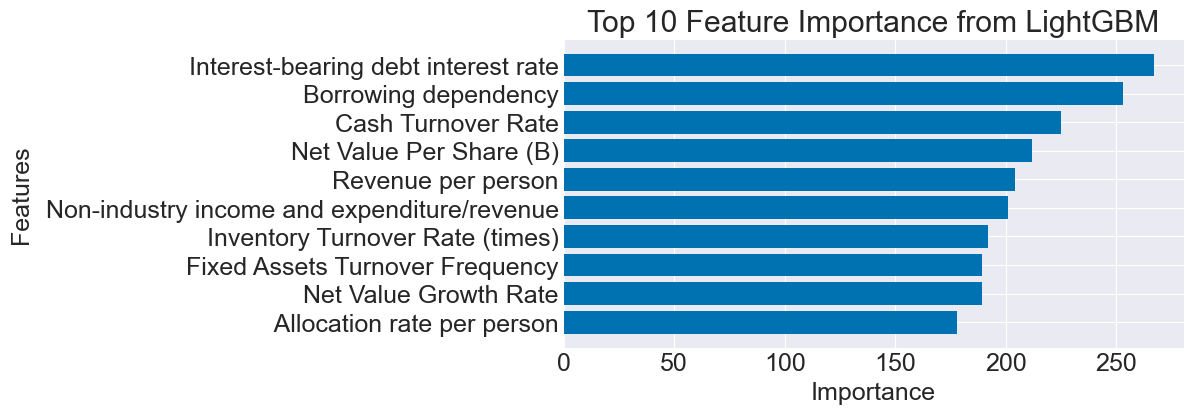

In [36]:
# Extract and plot feature importance
lgbm_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(lgbm_importance)

# Plot the feature importance
plt.figure(figsize=(8, 4))
plt.barh(lgbm_importance['Feature'][:10], lgbm_importance['Importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importance from LightGBM')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## 2. Model Interpretation

/Users/ninhgiangnguyen/Library/Python/3.12/lib/python/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


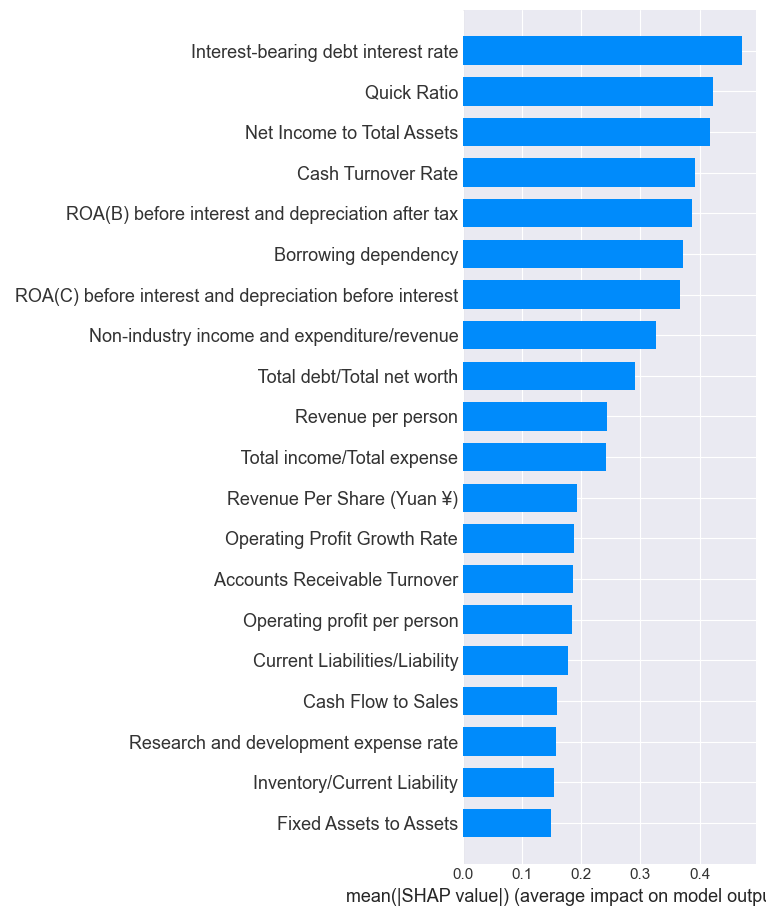

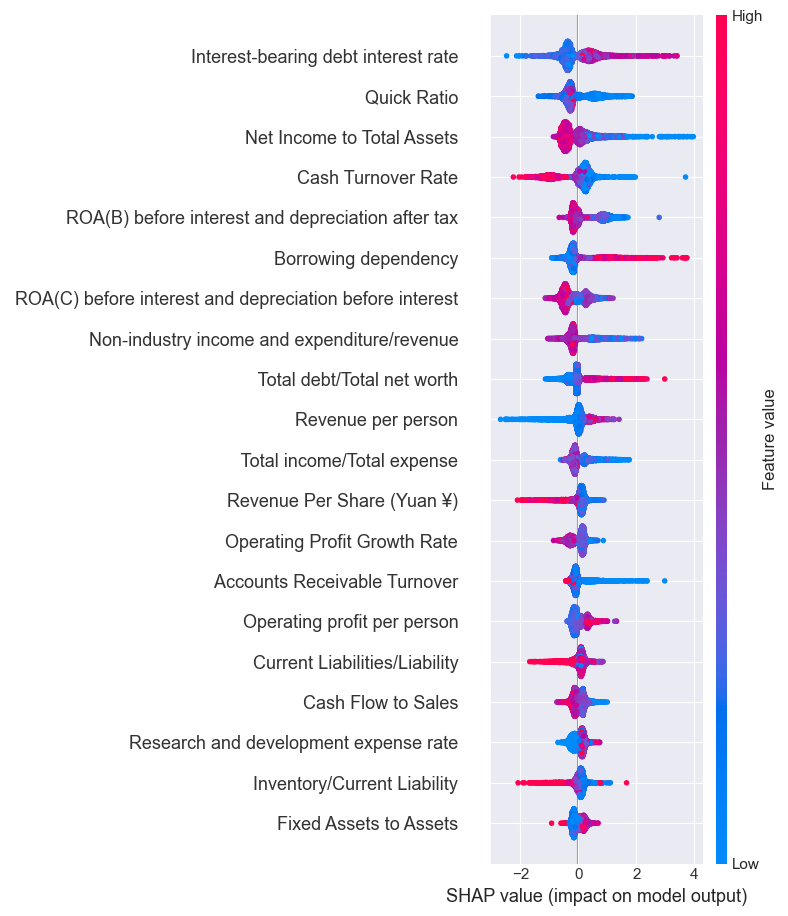

In [37]:
import shap

explainer = shap.TreeExplainer(lgbm_best)  # Use LightGBM model
shap_values = explainer.shap_values(X_train)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")  # For class 1 (bankruptcy)
shap.summary_plot(shap_values, X_train)  # Detailed summary plot


## PHASE 5: DEPLOYMENT and FINAL REPORTS

## Key Features and Their Impact
Based on the SHAP model analysis, the following features were identified as the most influential in predicting bankruptcy:

* Interest-Bearing Debt Interest Rate
  - A higher interest-bearing debt interest rate significantly increases the probability of bankruptcy. This reflects the financial burden imposed by high-interest liabilities, which can strain a company's cash flow and ability to meet obligations. 
  - Conversely, a lower rate reduces the bankruptcy risk.
* Quick Ratio
  - A higher quick ratio decreases the probability of bankruptcy, indicating better short-term liquidity and the company's ability to cover immediate liabilities. 
  - A lower ratio signals potential liquidity issues and a higher bankruptcy risk.
* Net Income to Total Sales
  - Lower net income to total sales is strongly associated with a higher bankruptcy probability, highlighting reduced profitability. 
  - However, a higher ratio does not necessarily guarantee financial stability, as other factors may offset profitability.
* Cash Turnover Rate
  - A higher cash turnover rate correlates with a lower probability of bankruptcy, suggesting efficient cash utilization. 
  - A lower rate, on the other hand, may indicate inefficiency and financial distress.
* Revenue Per Person
  - Lower revenue per person increases the likelihood of bankruptcy, reflecting inefficiencies in generating revenue per employee. 
  - However, higher values do not always guarantee financial stability, as revenue generation might not align with expense management.
* Borrowing Dependency
  - Higher borrowing dependency correlates with a higher probability of bankruptcy, as excessive reliance on borrowed funds indicates financial instability. 
  - A lower borrowing dependency reduces this risk but does not necessarily ensure solvency.

## Features with Limited or inconsistent Predictive Power
  - Fixed Assets to Total Assets Ratio
  - Cash Flow to Sales
  - Research and Development Expenses Rate
  - Operating Profit Per Person

These features may contribute indirectly or in specific contexts but do not provide strong signals in the current analysis.

In conclusion, the most critical features, such as the interest-bearing debt interest rate and quick ratio, align well with financial reasoning, highlighting liquidity, debt burden, and profitability as key indicators of bankruptcy risk. Features like net income to total sales and cash turnover rate offer nuanced insights, while others contribute less to predictive performance.

This refined interpretation not only improves clarity but also links statistical observations with economic rationale, making the results actionable and relevant for decision-making.


## PHASE 5: DEPLOYMENT

## 1. Export the model

In [38]:
import joblib
import streamlit as st

# Assuming `best_model` is your trained LightGBM model
joblib.dump(lgbm_best, 'bankruptcy_prediction_model.pkl')
print("Model saved as 'bankruptcy_prediction_model.pkl'")

Model saved as 'bankruptcy_prediction_model.pkl'


## 2. Create a Dashboard
run "streamlit run application.py" in the terminal, it will return this 
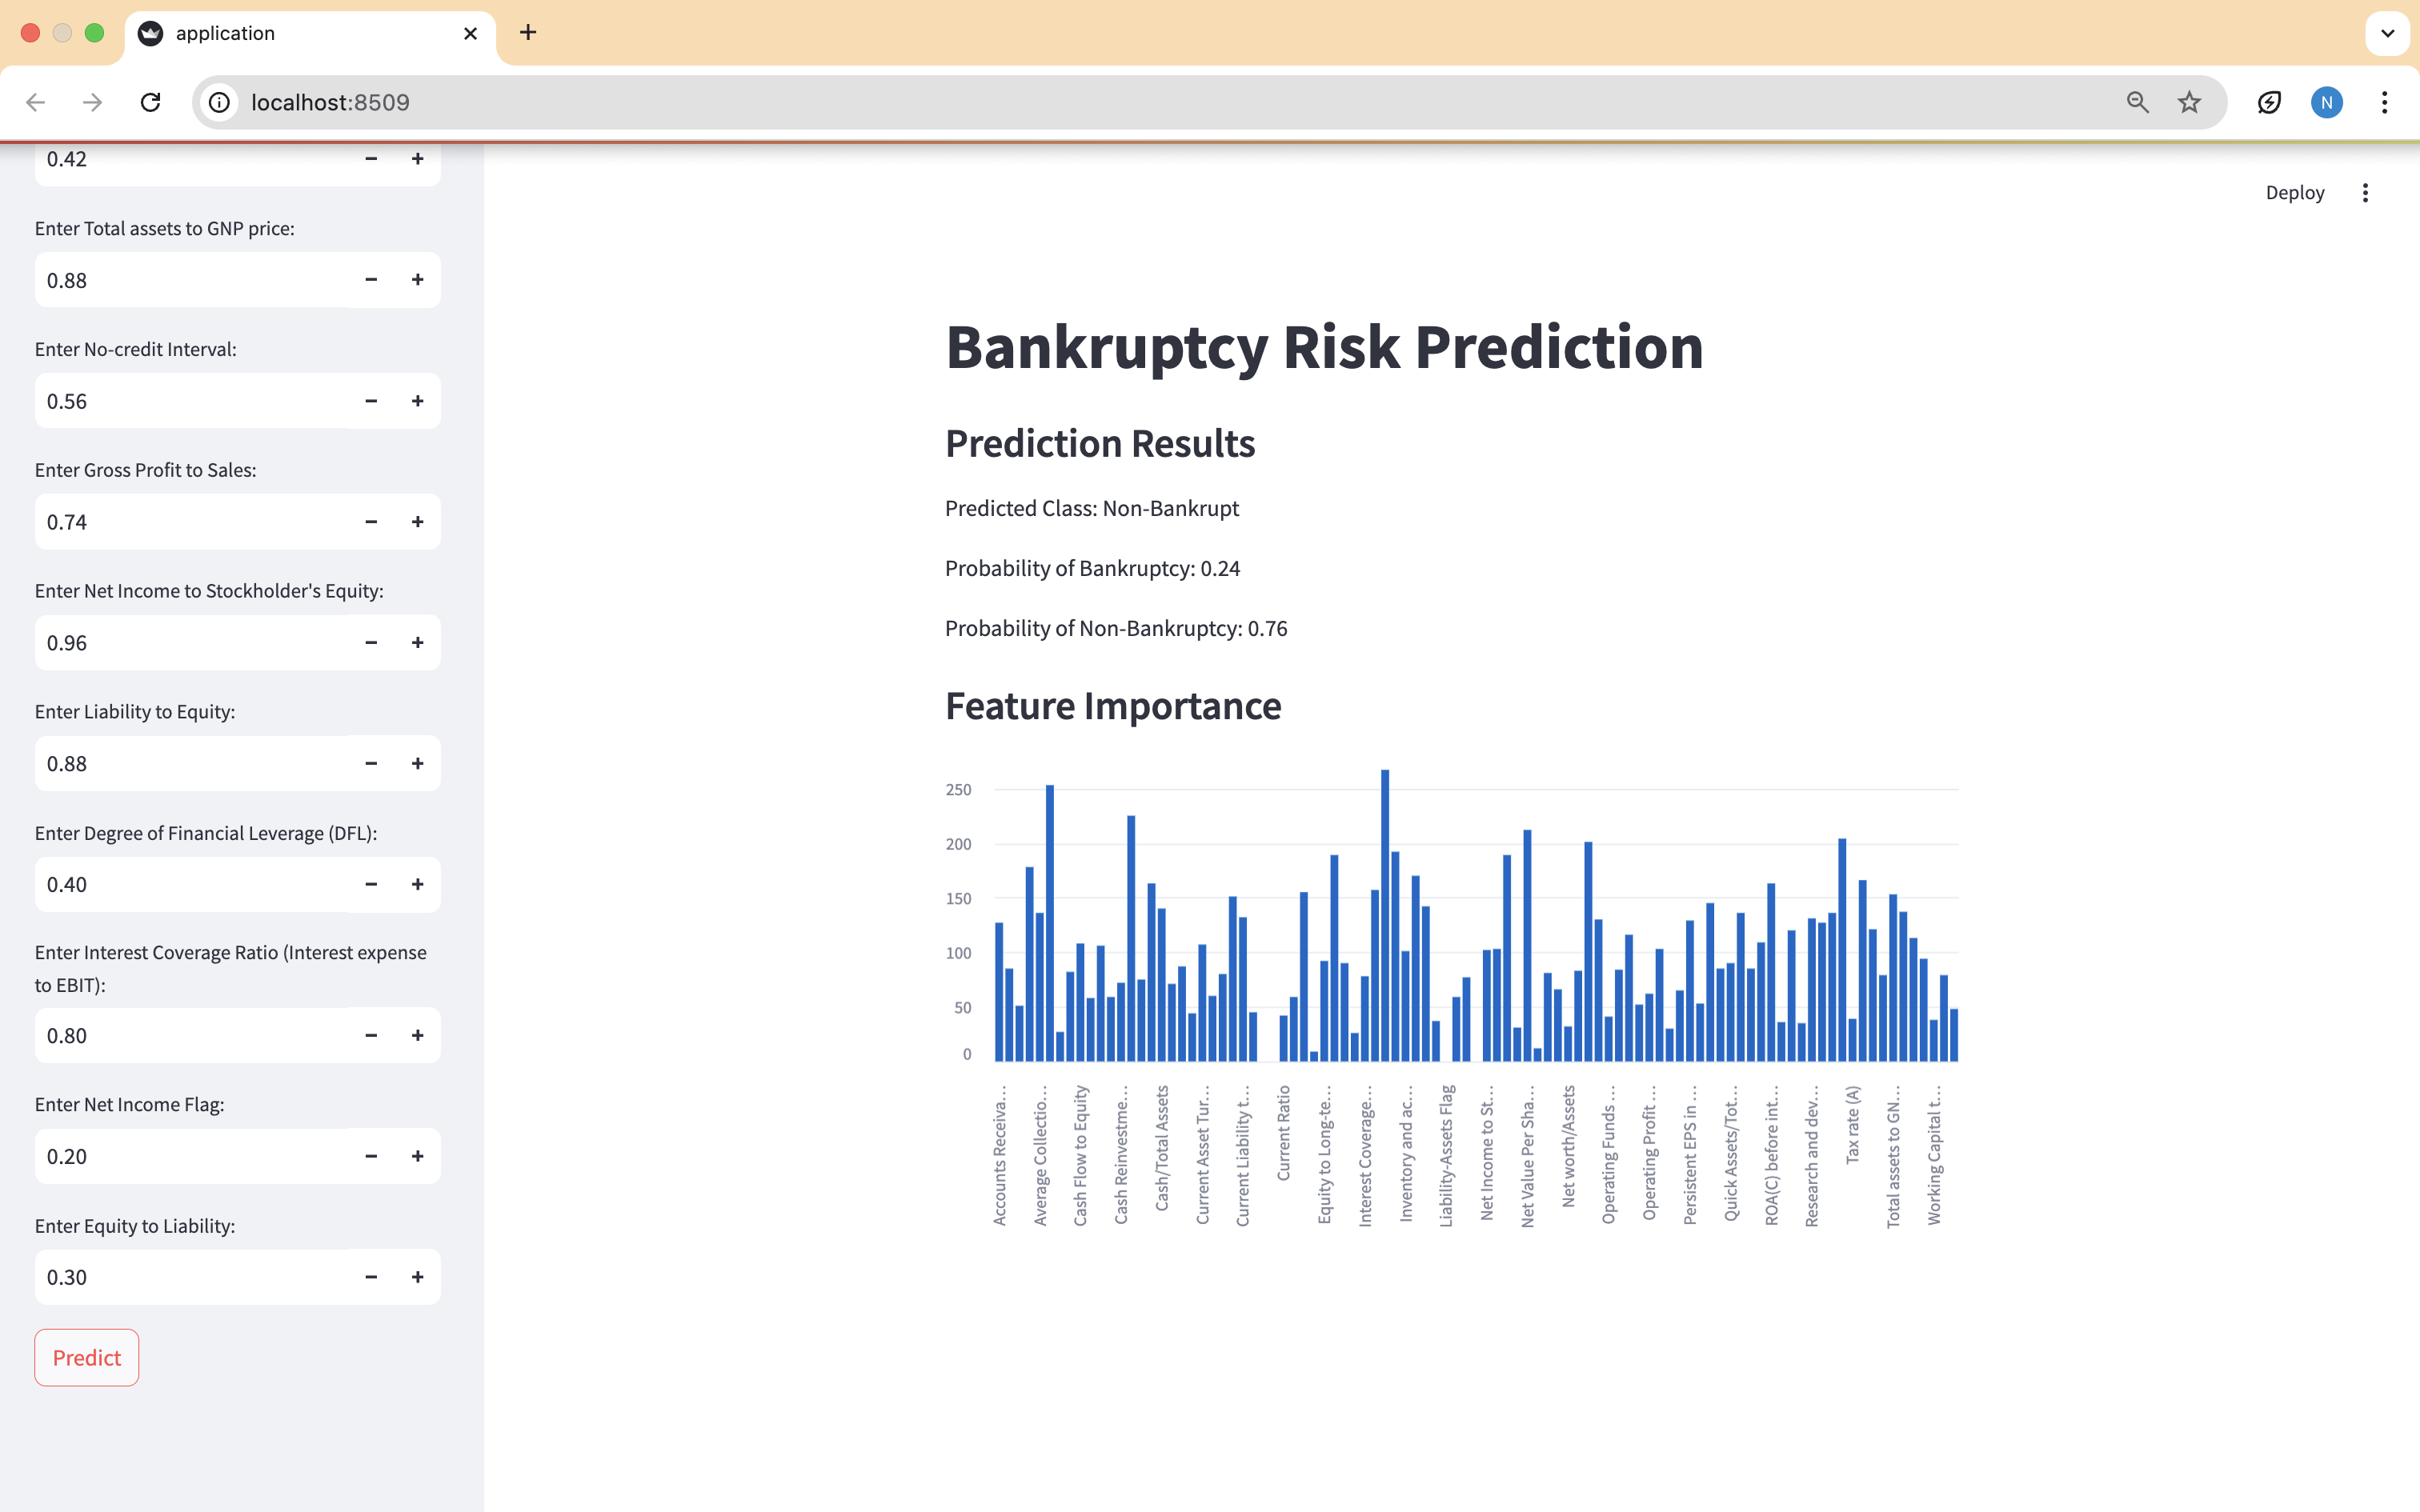
